In [ ]:
!pip install ipython==7.34.0 ipykernel==5.5.6
!pip install import_ipynb

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Physics-Informed Neural Networks/Demo/fenics_cfd/neural_network'
os.chdir(path)

import import_ipynb
from data_loading import FlowFieldDataset, train_test_split
from nn_modules import SuperResolutionCNN
from model_utils import train_model, test_model, evaluate_model, to_numpy
from visualize_data import plot_results, print_metrics, plot_numpy_matrices

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    torch.cuda.empty_cache()
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [3]:
def relative_error_loss(output, target):
  epsilon = 1e-6
  loss = torch.mean(torch.abs((output - target) / (target + epsilon)))
  return loss

In [3]:
# npy_velocity_dir = '../blood_flow_simulations/velocity_fields/npy_data'
# npy_pressure_dir = '../blood_flow_simulations/pressure_fields/npy_data'

npy_velocity_dir = '../test/velocity_fields/npy_data'
npy_pressure_dir = '../test/pressure_fields/npy_data'

dataset = FlowFieldDataset(npy_velocity_dir, npy_pressure_dir, load_all_data=False)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

batch_size = 1
num_epochs = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

hidden_layers = np.array([16, 32, 32, 64, 32, 32, 16]) # 32, 32, 32, 32, 32, 32, 32,
model = SuperResolutionCNN(hidden_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

log_interval = 1
model_save_path = '../logs/model_parameters'
loss_save_path = '../logs/losses'

# model_load_path = '../logs/model_params/CNN_model_params_47_epoch_59.pt'
model_load_path = '../results/CNN/run_1/CNN_model_params_47.pt'
test_loss_save_path = '../logs/test_losses'

Dataset Loaded in 1.2050 s


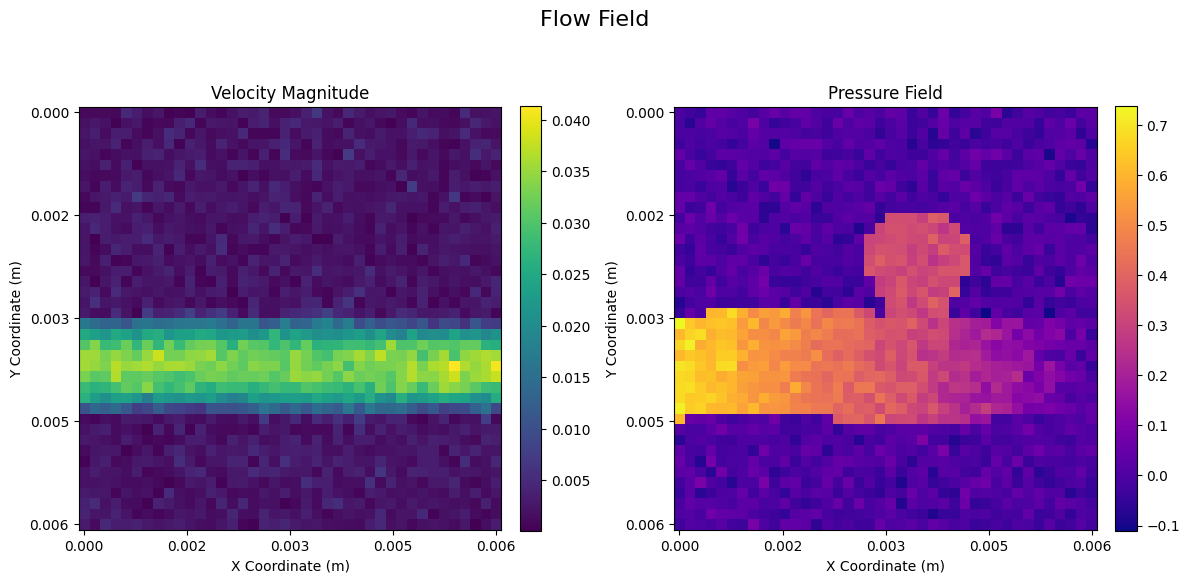

(<Figure size 1200x600 with 4 Axes>,
 array([<Axes: title={'center': 'Velocity Magnitude'}, xlabel='X Coordinate (m)', ylabel='Y Coordinate (m)'>,
        <Axes: title={'center': 'Pressure Field'}, xlabel='X Coordinate (m)', ylabel='Y Coordinate (m)'>],
       dtype=object))

In [4]:
(u_hr_tensor, p_hr_tensor), (u_lr_tensor, p_lr_tensor) = dataset[0]
u_hr_np, p_hr_np = to_numpy(u_hr_tensor), to_numpy(p_hr_tensor)
u_lr_np, p_lr_np = to_numpy(u_lr_tensor), to_numpy(p_lr_tensor)

plot_numpy_matrices(u_lr_np.transpose(1, 2, 0), p_lr_np.squeeze(0))

In [6]:
# - - - - - Training - - - - -

# data_losses = train_model(model, train_loader, optimizer, criterion, num_epochs, device,
#                           model_save_path=model_save_path, loss_save_path=loss_save_path, log_interval=log_interval)


In [9]:
# - - - - - Testing - - - - -

model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu'))) # map_location=torch.device('cpu')
avg_loss, results = test_model(model, test_loader, criterion, device, test_loss_save_path=test_loss_save_path, log_interval=log_interval)
velocity_metrics, pressure_metrics = evaluate_model(model, test_loader, device)

Step [1/2], Total Loss: 0.307021
Step [2/2], Total Loss: 0.031876
Average Test Loss: 0.169449


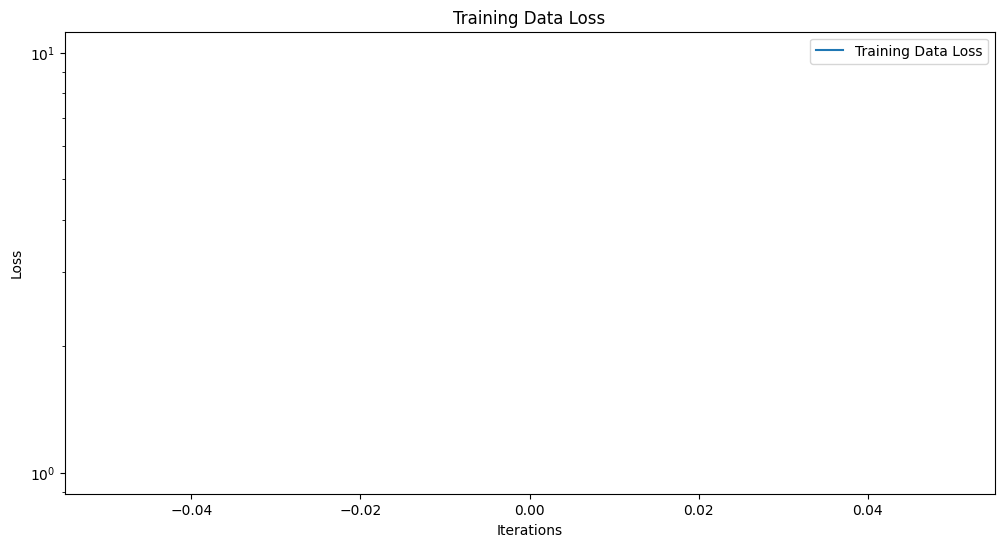

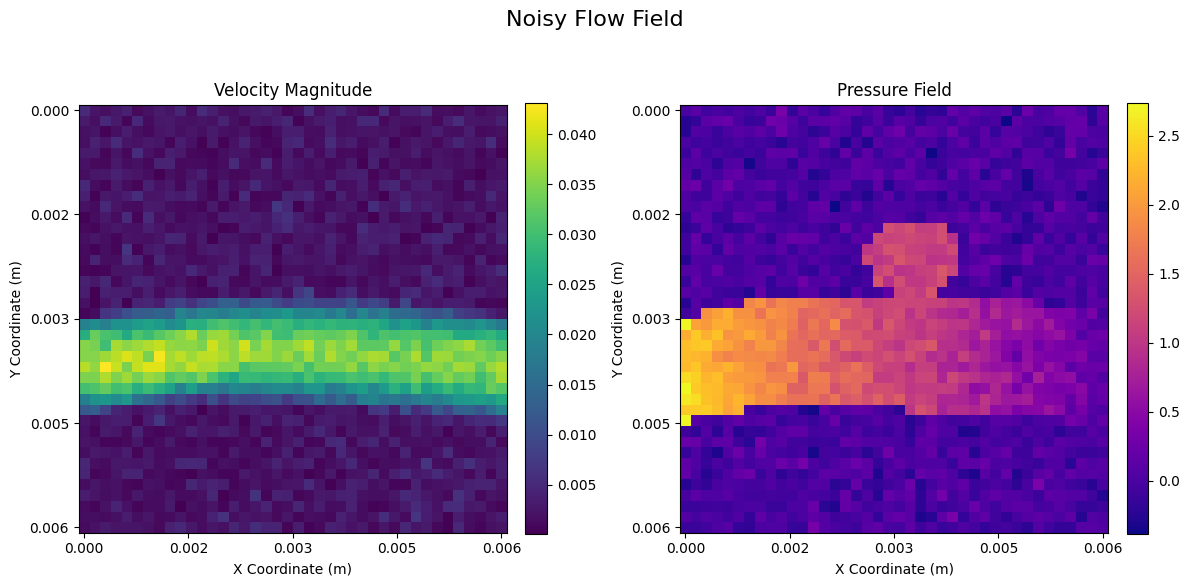

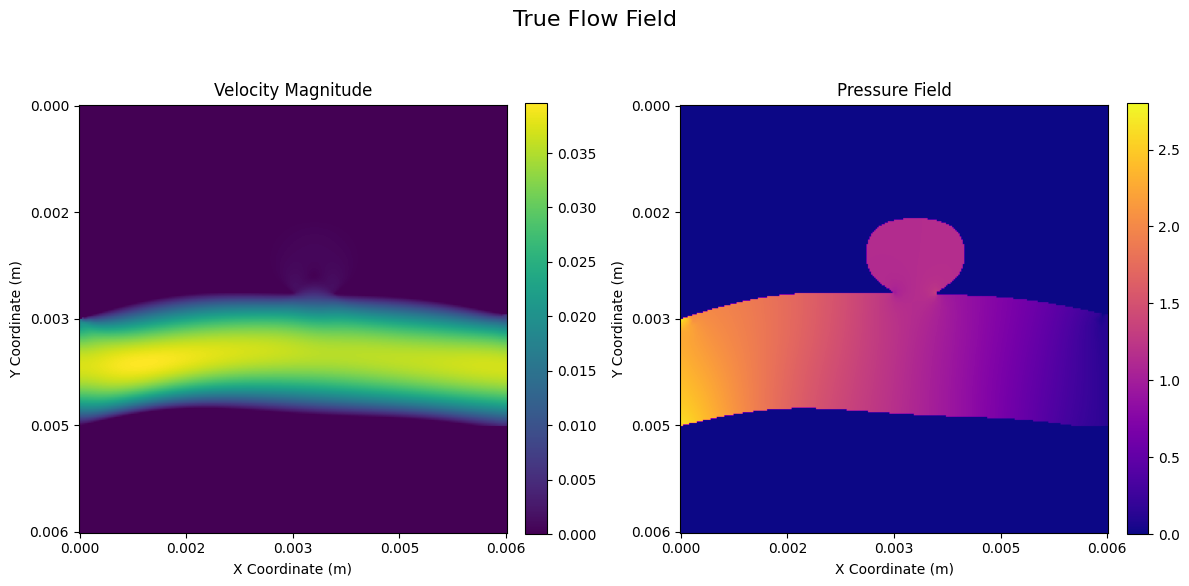

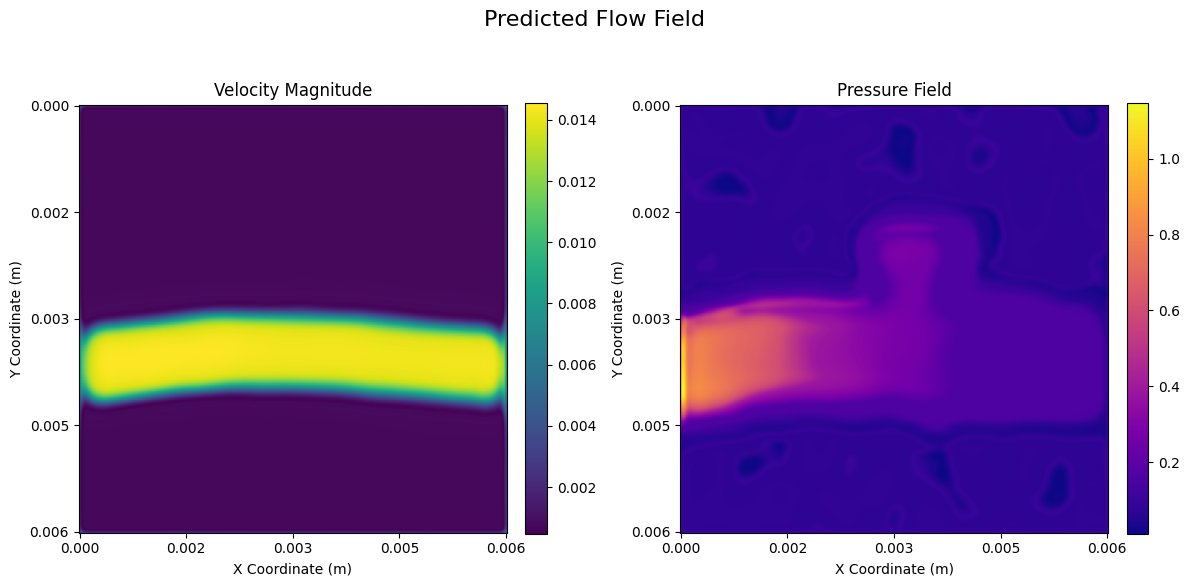

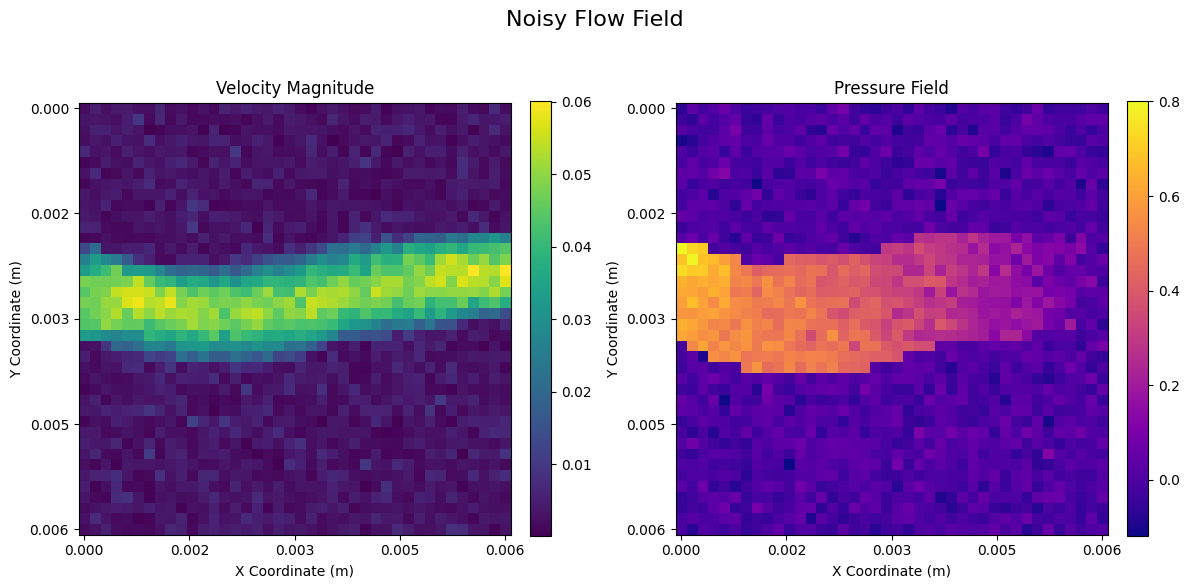

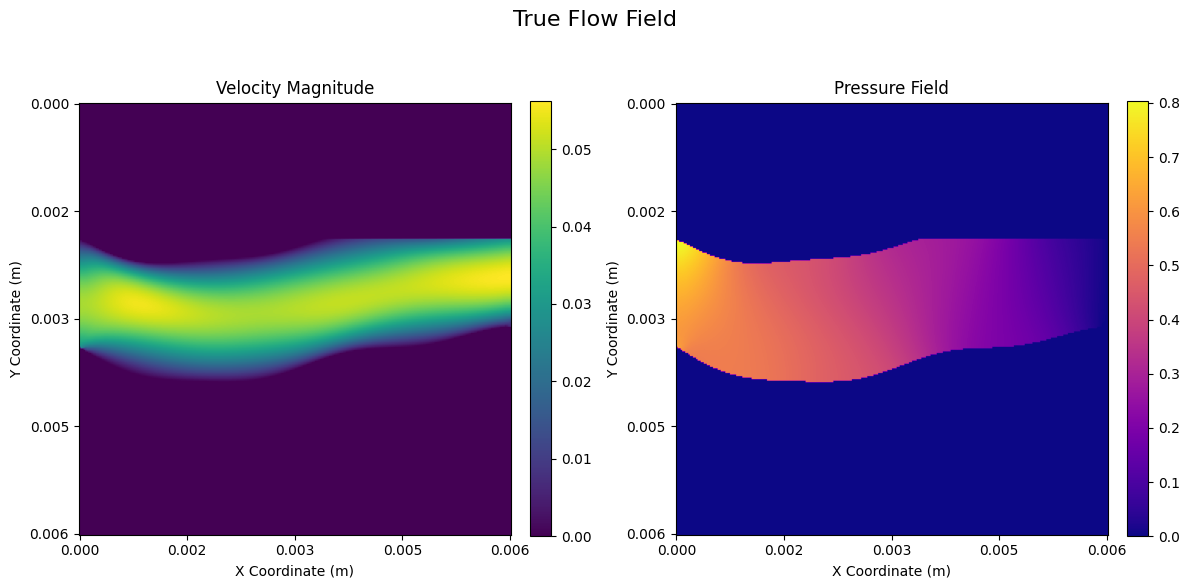

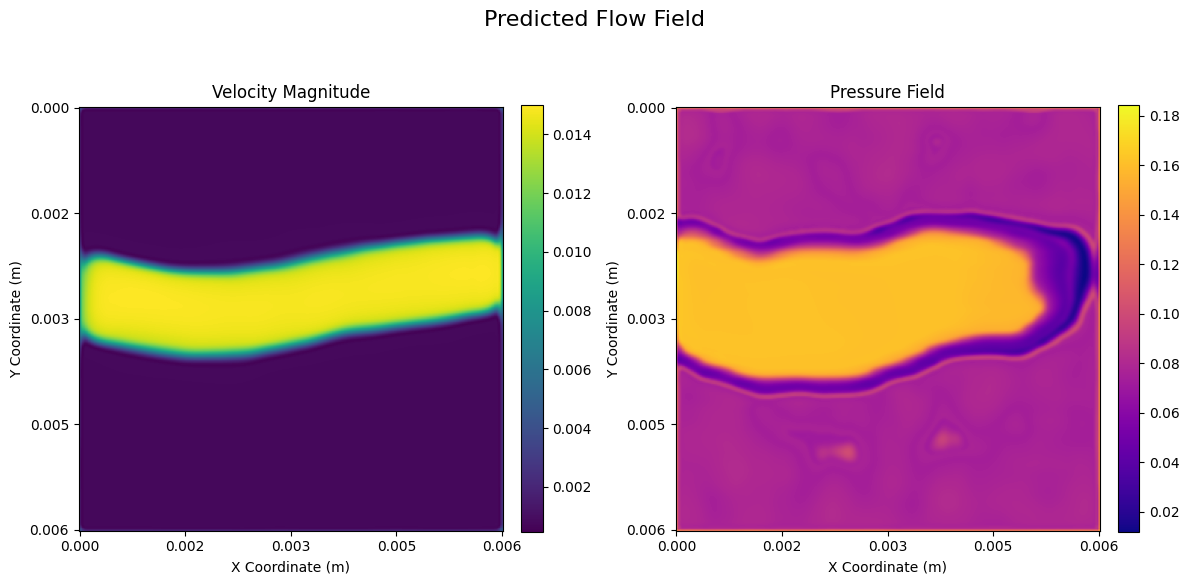

╔════════════════════════════════════════════════════════════╗
║ Results Summary                                            ║
╠════════════════════════════════════════════════════════════╣
║                   Average MSE: 0.0001
║     Velocity      Average PSNR: 92.8146 dB
║                   Average SSIM: 0.5152
╠════════════════════════════════════════════════════════════╣
║                   Average MSE: 0.1627
║     Pressure      Average PSNR: 10.8330 dB
║                   Average SSIM: 0.1991
╚════════════════════════════════════════════════════════════╝


In [10]:
# - - - - - Plotting - - - - -

plot_results(num_epochs, results, data_losses=[], log_interval=log_interval, num_samples_to_plot=2)
print_metrics(velocity_metrics, pressure_metrics)